In [3]:
import torch
import clip
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

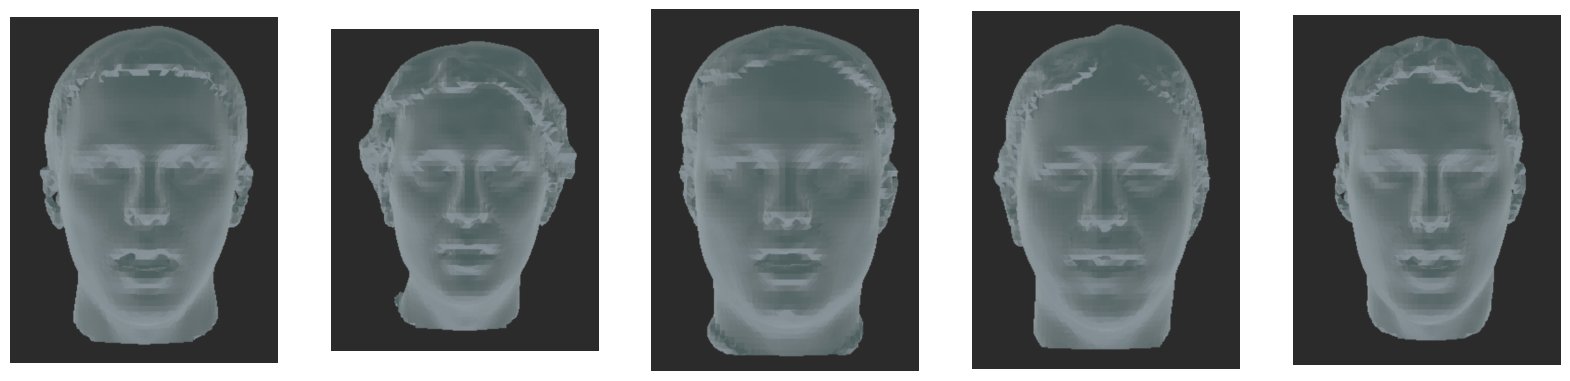

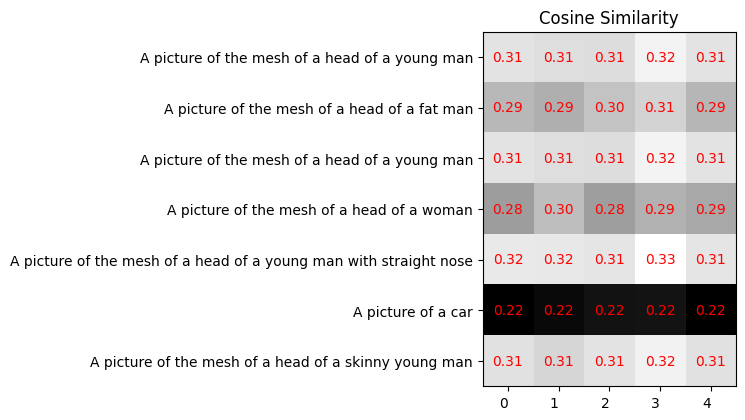

In [14]:
# image inputs
image_folder = '/Users/katharinaschmid/Text2Head/NPHM-main/rendering_data'

images = []
preprocessed_images = torch.tensor([])
for filename in os.listdir(image_folder):
    if filename.endswith(".png"):
        image = Image.open(os.path.join(image_folder, filename))
        images.append(image)
        preprocessed_image = preprocess(image).unsqueeze(0) # [1, 3, 224, 224]
        preprocessed_images = torch.cat((preprocessed_images, preprocessed_image), dim=0)
num_images = len(images)

fig, axes = plt.subplots(1, len(images), figsize=(20, 5))
for i, img in enumerate(images):
    ax = axes[i]
    ax.imshow(img)  # Display each image
    ax.axis('off')  # Turn off axis labels

plt.show()

# text inputs
general = "A picture of the mesh of a head of "
captions = []
captions.append(general + "a young man") 
captions.append(general + "a fat man")
captions.append(general + "a young man")
captions.append(general +"a woman")
captions.append(general + "a young man with straight nose")
captions.append("A picture of a car")
captions.append(general + "a skinny young man")

preprocessed_text = clip.tokenize(captions).to(device) # [num_captions, 77]

with torch.no_grad():
    image_features = model.encode_image(preprocessed_images) # [num_images, 512]
    text_features = model.encode_text(preprocessed_text) # [num_captions, 512]

# Normalize
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)

cosine_similarity = torch.matmul(text_features, image_features.T)
#print(cosine_similarity)

fig, ax = plt.subplots()
im = ax.imshow(cosine_similarity, cmap='gray')

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(images)))
ax.set_yticks(np.arange(len(captions)), labels=captions)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(captions)):
    for j in range(len(images)):
        similarity = cosine_similarity[i, j].numpy()
        formatted_similarity = "{:.2f}".format(similarity)  # Limit to 2 decimal places
        text = ax.text(j, i, formatted_similarity,
                       ha="center", va="center", color="r")

ax.set_title("Cosine Similarity")
fig.tight_layout()
plt.show()
